In [1]:
import GPy
import numpy as np
import math
from matplotlib import pyplot as plt

# Finding the gaussian process gradiants using GPy toolkit.

##
STEPS

1. Find the gradiant of a GP regressor using Gpy toolkit
2. Write my own code to do the same thing using Scikit learn
3. Compare the two answers and see if they agree

### true function: $$f(x)=x\sin(x)$$
Add uniform random noise in the range (-0.6,+0.6) and get 20 samples. We will fit a gaussian process to these samples.

In [2]:
def f(x):
    """define the main function here"""
    return x*np.sin(x)
def f_grad(x):
    """define the gradiant of the main function here"""
    return x*np.cos(x)+np.sin(x)

In [3]:
x = np.random.uniform(-3.,3.,(20,1))
y = f(x) + np.random.randn(20,1)*0.2
x_true=np.linspace(-3,3,100)
y_true=f(x_true)

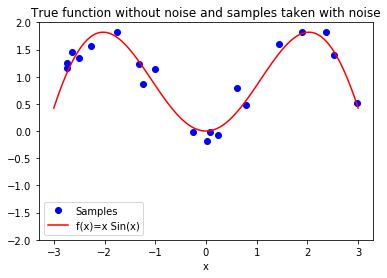

In [4]:
#plt.figure(figsize=(20,5))
plt.plot(x,y,'bo',label='Samples')
plt.plot(x_true,y_true,'r',label=r'f(x)=x Sin(x)')
plt.legend()
plt.ylim(-2,2)
plt.xlabel('x')
plt.title('True function without noise and samples taken with noise')
plt.show()

### Use GPy module to fit a gausian process to these samples

In [5]:
kernel = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)
m = GPy.models.GPRegression(x,y,kernel)
m.optimize_restarts(num_restarts = 10)

Optimization restart 1/10, f = 8.638882158342199
Optimization restart 2/10, f = 8.63888215837158
Optimization restart 3/10, f = 8.638882158352544
Optimization restart 4/10, f = 8.63888215834196
Optimization restart 5/10, f = 8.638882158354846
Optimization restart 6/10, f = 8.63888215867382
Optimization restart 7/10, f = 8.638882158343556
Optimization restart 8/10, f = 8.638882158385094
Optimization restart 9/10, f = 8.638882158364941
Optimization restart 10/10, f = 8.638882158368583


GP_regression.,value,constraints,priors
rbf.variance,1.67520312872764,+ve,
rbf.lengthscale,1.2690834241916913,+ve,
Gaussian_noise.variance,0.03826187843566071,+ve,


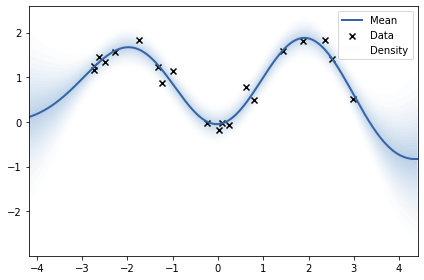

In [6]:
display(m)
fig = m.plot(plot_density=True)
#GPy.plotting.show(fig, filename='basic_gp_regression_density_notebook_optimized')

In [7]:
x_predict=np.array([[i] for i in np.arange(-3,3,0.01)])#dim=(1*number of prediction points)
y_predict,var_predict=m.predict(Xnew=x_predict)  
sigma_predict=np.sqrt(var_predict)

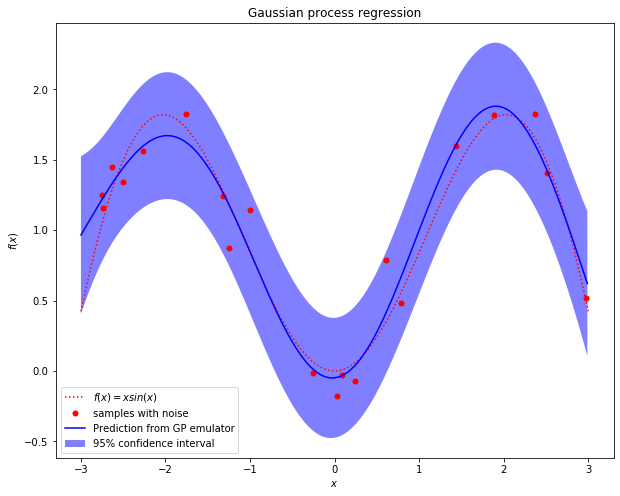

In [8]:
# Plot the function, the prediction and the 95% confidence interval
plt.figure(figsize=(10,8))
plt.plot(x_true,y_true, 'r:', label=r'$f(x) = x sin(x)$')
plt.plot(x,y, 'r.', markersize=10, label='samples with noise')
plt.plot(x_predict, y_predict, 'b-', label='Prediction from GP emulator')
#plt.fill(np.concatenate([x_predict, x_predict[::-1]]),np.concatenate([y_predict - 1.9600 * sigma_predict,(y_predict + 1.9600 * sigma_predict)[::-1]]),
#         alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.fill_between(x_predict.flatten(),y_predict.flatten() - 1.9600 * sigma_predict.flatten(),y_predict.flatten() + 1.9600 * sigma_predict.flatten(), alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.title('Gaussian process regression')
#plt.ylim(-0.5, 3)
plt.legend(loc='lower left')

### Find the gradiant of the above Gaussian process and plot it in the same plot. Use inbuilt tool of Gpy library

In [9]:
mean_grad,var_grad=m.predict_jacobian(Xnew=x_predict)
sigma_grad=np.sqrt(np.reshape(var_grad,(600,1)))
mean_grad=np.reshape(mean_grad,(600,1))

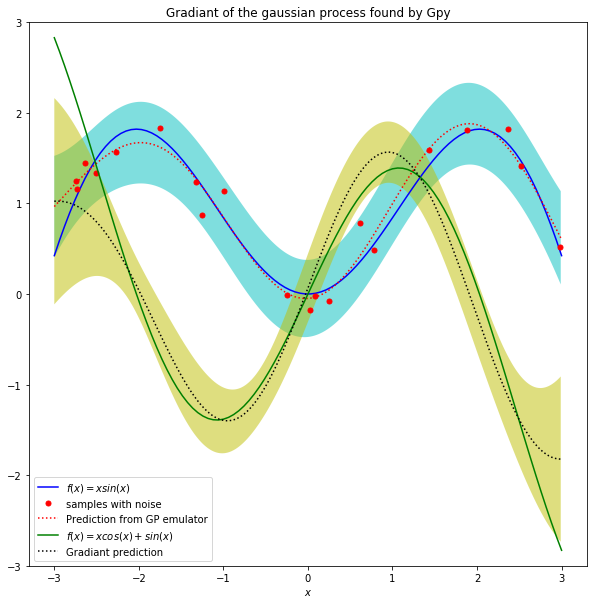

In [10]:
# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
plt.figure(figsize=(10,10))
plt.plot(x_true,y_true, 'b-', label=r'$f(x) = x sin(x)$')
plt.plot(x,y, 'r.', markersize=10, label='samples with noise')
plt.plot(x_predict, y_predict, 'r:', label='Prediction from GP emulator')
plt.fill_between(x_predict.flatten(),y_predict.flatten() - 1.9600 * sigma_predict.flatten(),y_predict.flatten() + 1.9600 * sigma_predict.flatten(), alpha=.5, fc='c', ec='None')
plt.xlabel('$x$')
plt.plot(x_true,f_grad(x_true), 'g', label=r'$f(x) = xcos(x) + sin(x)$')
plt.plot(x_predict, mean_grad, 'k:', label='Gradiant prediction')
plt.fill_between(x_predict.flatten(),mean_grad.flatten() - 1.9600 * sigma_grad.flatten(),mean_grad.flatten() + 1.9600 * sigma_grad.flatten(), alpha=.5, fc='y', ec='None')
plt.title('Gradiant of the gaussian process found by Gpy')
plt.ylim(-3, 3)
plt.legend(loc='lower left')

# Now we will write our own code (instead of using Gpy toolkit) to find the gradiant of the GP with uncertinity. 

#### Get trained GP parameters. We still use Gpy to get this. But this can easily replaced with scikit learn Gaussian process toolkits.

In [11]:
params=m.param_array
print('rbf variance {}, rbf length scale {}, noise variance {}'.format(*params))

rbf variance 1.67520312872764, rbf length scale 1.2690834241916913, noise variance 0.03826187843566071


#### Define functions that calculates rbf_covariance and it's first and second derivative

In [12]:
def cov_k(x_i,x_j,var_f=params[0],L=params[1]):
    """Takes two x values as inputs and calculate the rbf kernal covariance between the two with the trained 
    rbf lenght value
    k(x_i,x_j)"""
    return (var_f)*np.exp(-1*((x_i-x_j)**2)/(2*(L**2)))

In [13]:
def cov_dK_dx_star(x_star,x,L=params[1]):
    """Calculate the first derivative of rbf kernal wrt the first parameter (x_star)"""
    return -(1/(L**2))*(x_star-x)*cov_k(x_star,x)

In [14]:
def cov_d2k_dXdX(x_star,x,L=params[1]):
    """Calculate the second derivative (only cross terms) of the rbf kernal which is symetric under change of differentiation order
    (x_star or x)"""
    return (1/(L**2))*(1-(((x_star-x)**2)*(1/(L**2))))*cov_k(x_star,x)

#### Functions to define the covariance matrices for many prediction points for the GP

In [15]:
def generate_K(X_i,X_j):
    """Generates the full covariance for the two input arrays X_i and X_j"""
    raws=len(X_i)
    clmns=len(X_j)
    K=np.zeros((raws,clmns))
    for i in range(0,raws):
        for j in range(0,clmns):
            K[i][j]=cov_k(X_i[i][0],X_j[j][0])
    return K

In [16]:
def generate_dK(X_i,X_j):
    """Generate first derivative matrix of the kernal for two input arrays"""
    raws=len(X_i)
    clmns=len(X_j)
    K=np.zeros((raws,clmns))
    for i in range(0,raws):
        for j in range(0,clmns):
            K[i][j]=cov_dK_dx_star(X_i[i][0],X_j[j][0])
    return K

In [17]:
def generate_d2K(X_i,X_j):
    """Second derivative matrix of the kernal. Evaluvated at X_i, X_j points"""
    raws=len(X_i)
    clmns=len(X_j)
    K=np.zeros((raws,clmns))
    for i in range(0,raws):
        for j in range(0,clmns):
      #      if i==j:
                #For diaganal values there is an extra negative sign
      #          K[i][j]=-cov_d2k_dXdX(X_i[i][0],X_j[j][0])
      #      else:
                K[i][j]=cov_d2k_dXdX(X_i[i][0],X_j[j][0])

    return K

#### Finding the mean of the gradiant using above defined functions

In [18]:
k=generate_K(x,x)
noise_var=np.diag([params[2] for i in range(0,k.shape[0])])
woodbury_matrix=np.linalg.inv(noise_var+k)

In [19]:
dK=generate_dK(x_predict,x)

In [20]:
#dK.shape

In [21]:
mean_grad_my=np.matmul(dK,np.matmul(woodbury_matrix,y))

In [22]:
np.linalg.inv(woodbury_matrix).diagonal()

array([1.71346501, 1.71346501, 1.71346501, 1.71346501, 1.71346501,
       1.71346501, 1.71346501, 1.71346501, 1.71346501, 1.71346501,
       1.71346501, 1.71346501, 1.71346501, 1.71346501, 1.71346501,
       1.71346501, 1.71346501, 1.71346501, 1.71346501, 1.71346501])

In [23]:
#mean_grad_my-mean_grad

In [24]:
np.matmul(woodbury_matrix,y)

array([[-1.97829068],
       [ 7.73986186],
       [-0.7046154 ],
       [-0.24606547],
       [-0.86555387],
       [ 9.5715379 ],
       [ 0.69645498],
       [-3.3972697 ],
       [ 0.23316588],
       [-2.64912109],
       [-0.25637172],
       [-0.67420404],
       [-3.26051393],
       [-4.74849117],
       [-8.03957866],
       [-1.67898725],
       [-2.98043047],
       [ 3.25457063],
       [ 5.36232388],
       [ 5.64824886]])

In [25]:
np.matmul(woodbury_matrix,y)

array([[-1.97829068],
       [ 7.73986186],
       [-0.7046154 ],
       [-0.24606547],
       [-0.86555387],
       [ 9.5715379 ],
       [ 0.69645498],
       [-3.3972697 ],
       [ 0.23316588],
       [-2.64912109],
       [-0.25637172],
       [-0.67420404],
       [-3.26051393],
       [-4.74849117],
       [-8.03957866],
       [-1.67898725],
       [-2.98043047],
       [ 3.25457063],
       [ 5.36232388],
       [ 5.64824886]])

In [26]:
len(x_predict.flatten())

600

In [27]:
first_dK=generate_dK(x_predict,x_predict).diagonal()

In [28]:
fffgg=m.kern.gradients_X(np.ones((600,1)),x_predict)

In [29]:
fffgg

array([[ 335.03411228],
       [ 335.01312923],
       [ 334.97134157],
       [ 334.90875685],
       [ 334.82538643],
       [ 334.72124558],
       [ 334.59635339],
       [ 334.45073281],
       [ 334.28441065],
       [ 334.09741751],
       [ 333.88978786],
       [ 333.66155995],
       [ 333.41277584],
       [ 333.14348139],
       [ 332.85372619],
       [ 332.54356364],
       [ 332.21305084],
       [ 331.86224863],
       [ 331.49122154],
       [ 331.1000378 ],
       [ 330.68876927],
       [ 330.25749147],
       [ 329.80628354],
       [ 329.33522819],
       [ 328.8444117 ],
       [ 328.33392388],
       [ 327.80385808],
       [ 327.25431107],
       [ 326.68538313],
       [ 326.09717792],
       [ 325.4898025 ],
       [ 324.86336728],
       [ 324.21798598],
       [ 323.55377561],
       [ 322.87085642],
       [ 322.16935189],
       [ 321.44938866],
       [ 320.71109648],
       [ 319.95460822],
       [ 319.1800598 ],
       [ 318.38759013],
       [ 317.577

In [30]:
dddd2=m.kern.gradients_XX_diag(np.ones((600,1)),x_predict)

In [31]:
dddd2

array([[[1.04012882]],

       [[1.04012882]],

       [[1.04012882]],

       [[1.04012882]],

       [[1.04012882]],

       [[1.04012882]],

       [[1.04012882]],

       [[1.04012882]],

       [[1.04012882]],

       [[1.04012882]],

       [[1.04012882]],

       [[1.04012882]],

       [[1.04012882]],

       [[1.04012882]],

       [[1.04012882]],

       [[1.04012882]],

       [[1.04012882]],

       [[1.04012882]],

       [[1.04012882]],

       [[1.04012882]],

       [[1.04012882]],

       [[1.04012882]],

       [[1.04012882]],

       [[1.04012882]],

       [[1.04012882]],

       [[1.04012882]],

       [[1.04012882]],

       [[1.04012882]],

       [[1.04012882]],

       [[1.04012882]],

       [[1.04012882]],

       [[1.04012882]],

       [[1.04012882]],

       [[1.04012882]],

       [[1.04012882]],

       [[1.04012882]],

       [[1.04012882]],

       [[1.04012882]],

       [[1.04012882]],

       [[1.04012882]],

       [[1.04012882]],

       [[1.04012

In [32]:
var_grad_my=generate_d2K(x_predict,x_predict)-np.matmul(np.matmul(dK,woodbury_matrix),dK.T)

In [33]:
_,vvvv=m.predict_jacobian(x_predict, full_cov=True)

In [34]:
pp=vvvv.flatten()-var_grad_my.flatten()

In [35]:
pp[578]

3.9073661407124094e-11

In [36]:
vvvv.diagonal()

array([[[0.33731144, 0.3314436 , 0.32557831, 0.31971829, 0.31386626,
         0.30802489, 0.30219687, 0.29638484, 0.29059142, 0.28481923,
         0.27907081, 0.27334872, 0.26765546, 0.26199349, 0.25636525,
         0.25077312, 0.24521944, 0.23970652, 0.23423661, 0.22881192,
         0.2234346 , 0.21810674, 0.21283041, 0.20760759, 0.20244022,
         0.19733018, 0.19227928, 0.18728928, 0.18236187, 0.1774987 ,
         0.17270132, 0.16797124, 0.1633099 , 0.15871867, 0.15419885,
         0.14975168, 0.14537833, 0.1410799 , 0.13685743, 0.13271187,
         0.12864412, 0.12465501, 0.1207453 , 0.11691566, 0.11316673,
         0.10949906, 0.10591313, 0.10240935, 0.09898807, 0.09564959,
         0.09239412, 0.0892218 , 0.08613274, 0.08312695, 0.08020439,
         0.07736498, 0.07460854, 0.07193487, 0.06934367, 0.06683463,
         0.06440734, 0.06206136, 0.05979619, 0.05761127, 0.05550601,
         0.05347975, 0.05153179, 0.04966137, 0.0478677 , 0.04614994,
         0.04450722, 0.0429386 , 0

In [37]:
generate_d2K(x_predict,x_predict).diagonal()

array([1.04012882, 1.04012882, 1.04012882, 1.04012882, 1.04012882,
       1.04012882, 1.04012882, 1.04012882, 1.04012882, 1.04012882,
       1.04012882, 1.04012882, 1.04012882, 1.04012882, 1.04012882,
       1.04012882, 1.04012882, 1.04012882, 1.04012882, 1.04012882,
       1.04012882, 1.04012882, 1.04012882, 1.04012882, 1.04012882,
       1.04012882, 1.04012882, 1.04012882, 1.04012882, 1.04012882,
       1.04012882, 1.04012882, 1.04012882, 1.04012882, 1.04012882,
       1.04012882, 1.04012882, 1.04012882, 1.04012882, 1.04012882,
       1.04012882, 1.04012882, 1.04012882, 1.04012882, 1.04012882,
       1.04012882, 1.04012882, 1.04012882, 1.04012882, 1.04012882,
       1.04012882, 1.04012882, 1.04012882, 1.04012882, 1.04012882,
       1.04012882, 1.04012882, 1.04012882, 1.04012882, 1.04012882,
       1.04012882, 1.04012882, 1.04012882, 1.04012882, 1.04012882,
       1.04012882, 1.04012882, 1.04012882, 1.04012882, 1.04012882,
       1.04012882, 1.04012882, 1.04012882, 1.04012882, 1.04012

In [38]:
np.matmul(np.matmul(dK,woodbury_matrix),dK.T).diagonal()

array([0.70281742, 0.70868526, 0.71455054, 0.72041056, 0.7262626 ,
       0.73210396, 0.73793198, 0.74374402, 0.74953743, 0.75530963,
       0.76105804, 0.76678013, 0.77247339, 0.77813536, 0.7837636 ,
       0.78935574, 0.79490941, 0.80042233, 0.80589224, 0.81131693,
       0.81669426, 0.82202211, 0.82729844, 0.83252126, 0.83768863,
       0.84279867, 0.84784957, 0.85283957, 0.85776698, 0.86263015,
       0.86742753, 0.87215761, 0.87681895, 0.88141018, 0.88593   ,
       0.89037717, 0.89475052, 0.89904894, 0.90327142, 0.90741698,
       0.91148472, 0.91547383, 0.91938355, 0.92321318, 0.92696211,
       0.93062978, 0.93421572, 0.9377195 , 0.94114077, 0.94447925,
       0.94773472, 0.95090704, 0.9539961 , 0.95700189, 0.95992445,
       0.96276386, 0.9655203 , 0.96819397, 0.97078516, 0.97329421,
       0.9757215 , 0.97806748, 0.98033265, 0.98251756, 0.98462282,
       0.98664908, 0.98859705, 0.99046747, 0.99226113, 0.99397889,
       0.99562161, 0.99719023, 0.99868571, 1.00010905, 1.00146

In [39]:
#var_grad_my.diagonal()

In [40]:
#This step is questionable. Some of the variance values are negative. Have to look into this issue
sigma_grad_my=np.sqrt([i for i in var_grad_my.diagonal()])

In [41]:
#var_grad_my.diagonal()

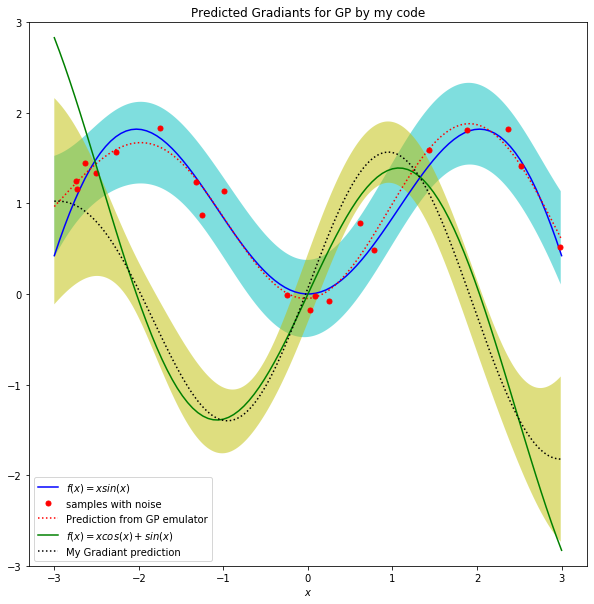

In [42]:
# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
plt.figure(figsize=(10,10))
plt.plot(x_true,y_true, 'b-', label=r'$f(x) = x sin(x)$')
plt.plot(x,y, 'r.', markersize=10, label='samples with noise')
plt.plot(x_predict, y_predict, 'r:', label='Prediction from GP emulator')
plt.fill_between(x_predict.flatten(),y_predict.flatten() - 1.9600 * sigma_predict.flatten(),y_predict.flatten() + 1.9600 * sigma_predict.flatten(), alpha=.5, fc='c', ec='None')
plt.xlabel('$x$')
plt.plot(x_true,f_grad(x_true), 'g', label=r'$f(x) = xcos(x) + sin(x)$')
plt.plot(x_predict, mean_grad_my, 'k:', label='My Gradiant prediction')
plt.fill_between(x_predict.flatten(),mean_grad_my.flatten() - 1.9600 * sigma_grad_my.flatten(),mean_grad_my.flatten() + 1.9600 * sigma_grad_my.flatten(), alpha=.5, fc='y', ec='None')
plt.title('Predicted Gradiants for GP by my code')
plt.ylim(-3, 3)
plt.legend(loc='lower left')

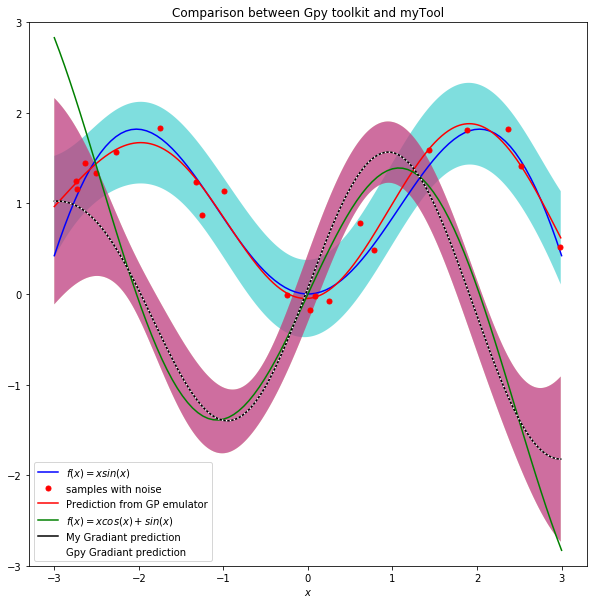

In [43]:

# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
plt.figure(figsize=(10,10))
plt.plot(x_true,y_true, 'b-', label=r'$f(x) = x sin(x)$')
plt.plot(x,y, 'r.', markersize=10, label='samples with noise')
plt.plot(x_predict, y_predict, 'r', label='Prediction from GP emulator')
plt.fill_between(x_predict.flatten(),y_predict.flatten() - 1.9600 * sigma_predict.flatten(),y_predict.flatten() + 1.9600 * sigma_predict.flatten(), alpha=.5, fc='c', ec='None')
plt.xlabel('$x$')
plt.plot(x_true,f_grad(x_true), 'g', label=r'$f(x) = xcos(x) + sin(x)$')
plt.plot(x_predict, mean_grad_my, 'k-', label='My Gradiant prediction')
plt.fill_between(x_predict.flatten(),mean_grad_my.flatten() - 1.9600 * sigma_grad_my.flatten(),mean_grad_my.flatten() + 1.9600 * sigma_grad_my.flatten(), alpha=.5, fc='y', ec='None')
plt.title('Comparison between Gpy toolkit and myTool')


plt.plot(x_predict, mean_grad, 'w:', label='Gpy Gradiant prediction')
plt.fill_between(x_predict.flatten(),mean_grad.flatten() - 1.9600 * sigma_grad.flatten(),mean_grad.flatten() + 1.9600 * sigma_grad.flatten(), alpha=.5, fc='m', ec='None')


plt.ylim(-3, 3)
plt.legend(loc='lower left')
